<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# Tarea 3: Transformers y Stacked AutoEncoders

Fuentes:

- [BRISC](https://www.kaggle.com/datasets/briscdataset/brisc2025)

**Rafael: para facilitar la diferenciacion del contenido escrito por el profesor y por mi se agregara mi contenido usando negritas, asimismo el codigo modificado/agregado por mi sera explicado**

# Descargando datos

Usaremos la librería kagglehub para descargar los datos. Por defecto, los datos son descargados en la `cache` de `.root` necesitamos moverlos a nuestro directorio luego de descargar.

**Tuvimos algunos problemas con el directorio de descarga, asi que ajustamos el mismo con la variable "path"**

In [121]:
import kagglehub
path = kagglehub.dataset_download('briscdataset/brisc2025')

print('Descarga de datos completa.', path)

Descarga de datos completa. /home/deeplearning/.cache/kagglehub/datasets/briscdataset/brisc2025/versions/5


In [122]:
!ls {path}

brisc2025


In [123]:
# quitar el anterior y usar copy para evitar descargar varias veces en un ambiente persistente (local)
!rm -r ./briscdataset
!cp -r {path}/brisc2025 ./briscdataset

Refresquen el directorio de Google Colab

# 🧠 BRISC 2025 Dataset Exploration

BRISC es un conjunto de datos de resonancias magnéticas de alta calidad, anotado por expertos, diseñado para la segmentación y clasificación de tumores cerebrales. Aborda limitaciones comunes en los conjuntos de datos existentes (p. ej., BraTS, Figshare), como el desequilibrio de clases, la focalización tumoral limitada y las inconsistencias en la anotación.

Esta sección provee métodos para entender los datos del dataset **BRISC 2025**. Está modificado para ser usado en `Google Colab` de un tutorial que funcionaba en `Kaggle`

1. Setup & Imports
2. Estructura del directorio  
3. Número de archivos y distribuciones
4. Representación gráfica de distribuciones
5. Numéro de clasificación por plano
6. Visualización de imágenes de muestra y máscaras
7. Histogramas de intensidad de píxeles
8. Análisis de metadatos de nombres de archivo
9. Ejemplo de superposición de máscaras
10. Cuadrícula aleatoria de muestras de clasificación


## ⚙️ 1. Setup & Imports

Librerías usadas por el tutorial. La mayoría conocidas:
- Archivo y manejo de directorios (`os`, `glob`)
- Datos (`pandas`, `numpy`)
- Procesamiento de imágenes (`PIL.Image`)
- Visualización (`matplotlib`)

Tomen en cuenta que usamos el directorio base luego de copiar en Google Colab.

In [124]:
# In[1] — Setup & Imports
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Render plots inline
%matplotlib inline


BASE_DIR = "briscdataset/"
print("✅ Final BASE_DIR =", BASE_DIR)



✅ Final BASE_DIR = briscdataset/


No cambien el código abajo, si copiaron bien los archivos debería verse como en la imagen

In [125]:
!ls {BASE_DIR}

classification_task  segmentation_task


## 📂 2. Estructura del directorio

Navegamos recursivamente en el `BASE_DIR` (profundidad=2)

In [126]:
# In[2] — Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)


## BRISC2025 Folder Layout:
/
  segmentation_task/
  classification_task/
segmentation_task/
  test/
  train/
  test/
    masks/
    images/
    masks/
    images/
  train/
    masks/
    images/
    masks/
    images/
classification_task/
  test/
  train/
  test/
    pituitary/
    no_tumor/
    meningioma/
    glioma/
    pituitary/
    no_tumor/
    meningioma/
    glioma/
  train/
    pituitary/
    no_tumor/
    meningioma/
    glioma/
    pituitary/
    no_tumor/
    meningioma/
    glioma/


## 📊 3. Distribución de archivos

Contando cada imagen `.jpg` en cada uno de los split/clases.


In [127]:
# File Count Logic (no need to change if BASE_DIR is fixed)
def count_patterns(patterns):
    return sum(len(glob.glob(p)) for p in patterns)

# Classification
splits = ["train", "test"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
cls_records = []
for sp in splits:
    total = 0
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        cnt = count_patterns([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': cnt})
        total += cnt
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': total})
df_cls = pd.DataFrame(cls_records)

# Segmentation
types_ = ["images", "masks"]
seg_records = []
for sp in splits:
    for tp in types_:
        pats = [
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.jpg"),
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.png")
        ]
        cnt = count_patterns(pats)
        seg_records.append({'Split': sp, 'Type': tp, 'Count': cnt})
df_seg = pd.DataFrame(seg_records)

# Display
print("### Classification Counts")
display(df_cls)
print("### Segmentation Counts")
display(df_seg)


### Classification Counts


,Split,Class,Count
0,train,glioma,1147
1,train,meningioma,1329
2,train,pituitary,1457
3,train,no_tumor,1067
4,train,Total,5000
5,test,glioma,254
6,test,meningioma,306
7,test,pituitary,300
8,test,no_tumor,140
9,test,Total,1000


### Segmentation Counts


,Split,Type,Count
0,train,images,3933
1,train,masks,3933
2,test,images,860
3,test,masks,860


## 📊 4. Gráficos por distribuciones

Visualización del conjunto de datos


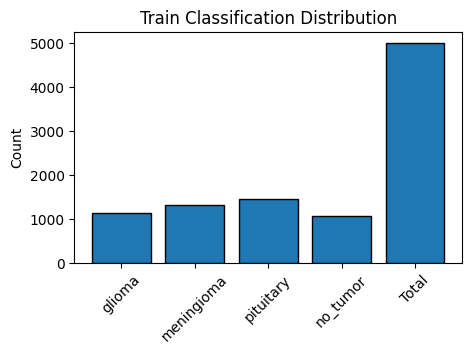

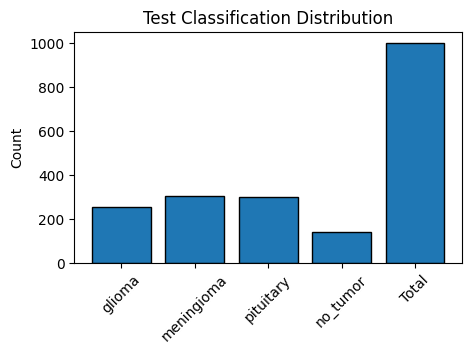

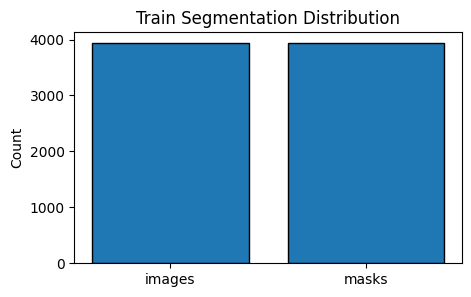

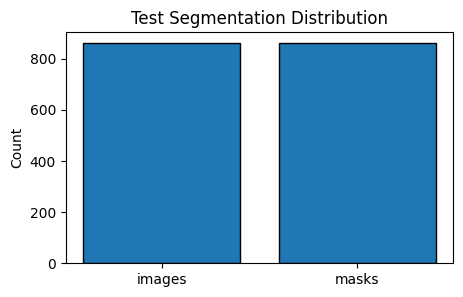

In [128]:
# In[4] — Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

for sp in splits:
    sub = df_seg[df_seg.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Type, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Segmentation Distribution")
    plt.ylabel("Count")
    plt.show()


## 📈 5. Clasificación por planos

Resumen anátomico dependiendo de los planos:

1. Ax: Axial
1. co: Coronal
1. sa: Sagittal

In [129]:
# In[5] — Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))


### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

## 🖼️ 6. Imagen de ejemplo y máscaras

Ejemplo de una imagen de clasificación con su imagen de segmentación.

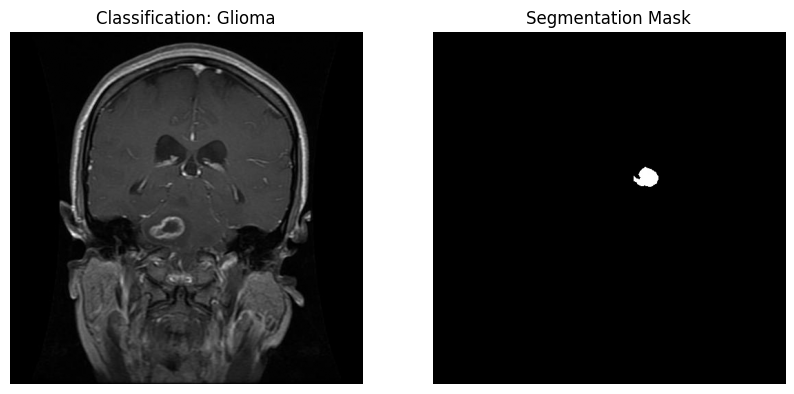

In [130]:
# In[6] — Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
mask_path = first_file(os.path.join(BASE_DIR, "segmentation_task/train/masks"), ["png","jpg"])

img  = Image.open(img_path)
mask = Image.open(mask_path)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Segmentation Mask");    axes[1].axis("off")
plt.show()

## 📈 7. Histogramas de frecuencias por píxeles

Píxeles de las imágenes y las máscaras.

/tmp/ipykernel_178301/3109520795.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr_img  = np.array(img).ravel()
/tmp/ipykernel_178301/3109520795.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr_mask = np.array(mask).ravel()


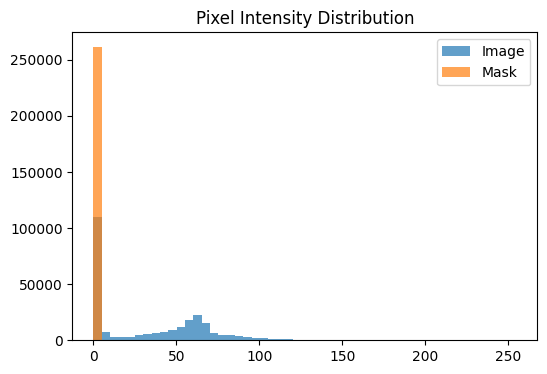

In [131]:
# In[7] — Histograms
arr_img  = np.array(img).ravel()
arr_mask = np.array(mask).ravel()

plt.figure(figsize=(6,4))
plt.hist(arr_img,  bins=50, alpha=0.7, label="Image")
plt.hist(arr_mask, bins=50, alpha=0.7, label="Mask")
plt.legend(); plt.title("Pixel Intensity Distribution"); plt.show()

## 📝 8. Parsing de metadata

Componentes del dataset transformados en una tabla. La columna Split dice a cuál corte irá cada imagen

In [132]:
# In[8] — Metadata Table
meta = []
for sp in splits:
    for cls in classes:
        # rafael: dependo de este objeto luego, asi que ahora el dataframe tiene TODAS las imagenes
        # antes solo tenia un subset
        files = glob.glob(os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg"))
        for f in files:
            parts = os.path.basename(f).split("_")
            meta.append({
                "Filename": os.path.basename(f),
                "Split": parts[1],
                "Index": parts[2],
                "Tumor": parts[3],
                "Plane": parts[4],
                "Sequence": parts[5].split(".")[0]
            })
df_meta = pd.DataFrame(meta)
print("### Sample Filename Metadata")
display(df_meta)

### Sample Filename Metadata


,Filename,Split,Index,Tumor,Plane,Sequence
0,brisc2025_train_00746_gl_co_t1.jpg,train,00746,gl,co,t1
1,brisc2025_train_00628_gl_co_t1.jpg,train,00628,gl,co,t1
2,brisc2025_train_00048_gl_ax_t1.jpg,train,00048,gl,ax,t1
3,brisc2025_train_00692_gl_co_t1.jpg,train,00692,gl,co,t1
4,brisc2025_train_00130_gl_ax_t1.jpg,train,00130,gl,ax,t1
...,...,...,...,...,...,...
5995,brisc2025_test_00649_no_co_t1.jpg,test,00649,no,co,t1
5996,brisc2025_test_00654_no_co_t1.jpg,test,00654,no,co,t1
5997,brisc2025_test_00633_no_co_t1.jpg,test,00633,no,co,t1
5998,brisc2025_test_00585_no_ax_t1.jpg,test,00585,no,ax,t1


## 🔍 9. ejemplo de Overlay de la máscara

Overlay de la máscara en rojo sobre la resonancia.

/tmp/ipykernel_178301/695026880.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img_rgb  = np.array(img.convert("RGB"))
/tmp/ipykernel_178301/695026880.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mask_arr = np.array(mask)


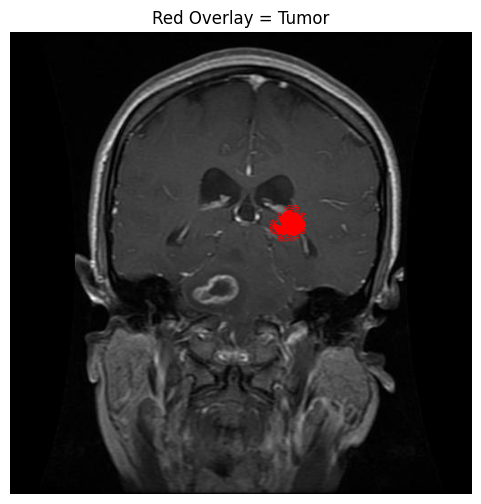

In [133]:
# In[9] — Overlay
img_rgb  = np.array(img.convert("RGB"))
mask_arr = np.array(mask)

overlay = img_rgb.copy()
overlay[mask_arr>0] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(overlay); plt.title("Red Overlay = Tumor"); plt.axis("off")
plt.show()

## 🔲 10. Grid aleatorio de ejemplos de clasificación

Desplegar un grid 3x3

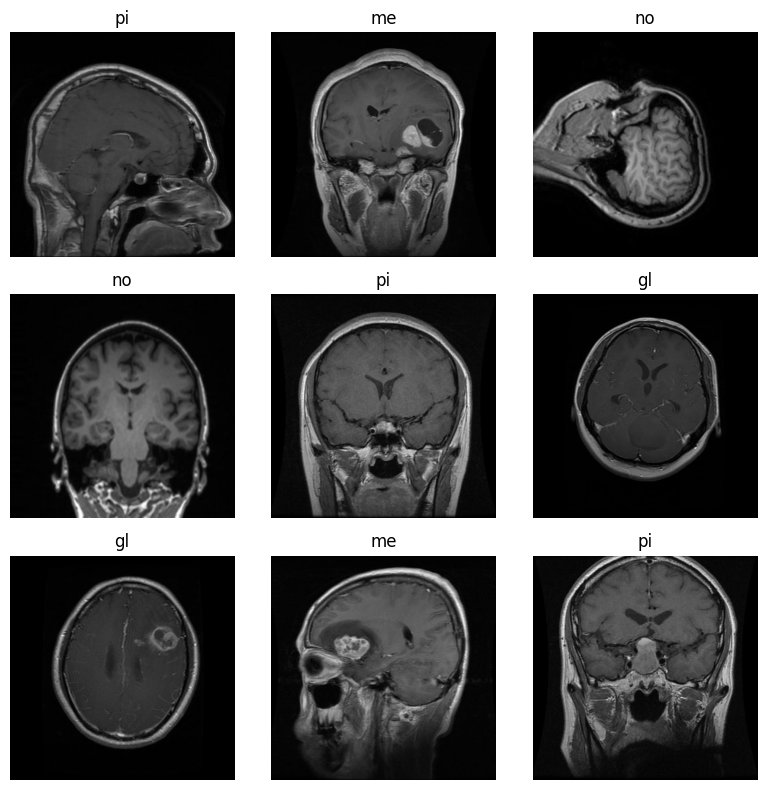

In [134]:
# In[10] — Random Grid
samples = glob.glob(os.path.join(BASE_DIR, "classification_task/train/*/*.jpg"))
grid = np.random.choice(samples, 9, replace=False)

fig, axes = plt.subplots(3,3, figsize=(8,8))
axes = axes.flatten()
for ax, fp in zip(axes, grid):
    im = Image.open(fp)
    cls = os.path.basename(fp).split("_")[3]
    ax.imshow(im, cmap="gray")
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Dataloader para clasificacion


**Hemos creado un dataloader para poder manejar y transformar los datos de forma sencilla y eficiente. Cosas que resaltar en este dataloader:**

1 - Carga todas las imagenes en memoria antes de ser usadas por los modelos, esto es mas rapido que ir a buscarlas en almacenamiento durante el entrenamiento. Esto solo es posible si todas las imagenes caben en memoria (La cantidad de datos no es tan grande)

2 - Hacemos distintas transformaciones a las imagenes al usarlas, entre ellas: Resize para que nuestros modelos no sean tan grandes, transformacion a tensor, normalizacion (calculamos un mean y std para todo el dataset)

3 - Tenemos dos posibles resizes. IMAGE_SIZE (que fue el que usamos para todos los modelos) y IMAGE_SIZE_AUTOENCODER (este fue una prueba para el stacked autoencoder para intentar reducir su tamaño

4 - Tenemos una funcion que crea los dataset de entrenamiento y validacion. Este carga todas las imagenes en memoria como se menciono antes, asi que no debe ser ejecutado multiples veces, sino la memoria se llenara rapidamente.

In [135]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

IMAGE_SIZE = 224 # para vit
IMAGE_SIZE_AUTOENCODER = 100 # probando para stacked autoencoder

# transformaciones, recibe el mean y desviacion
def get_transforms(mean, std, resize_size):
    return transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

# usar este objeto con cautela. Carga TODAS las imagenes en memoria
# para hacer mas rapido el entrenamiento. No deben crearse muchas instancias o
# la session crasheara.
# opcional dejar 3 canales (para el modelo de huggingface)
class BrainTumorDataset(Dataset):
    def __init__(self, df, root_dir, resize_size):
        self.label_map = {'gl': 0, 'me': 1, 'no': 2, 'pi': 3}
        self.images = []
        self.labels = []
        self.meta = []

        for _, row in df.iterrows():
            tumor_to_file = {
                "gl":"glioma",
                "me":"meningioma",
                "no":"no_tumor",
                "pi":"pituitary"
            }
            tumor = row['Tumor']
            filename = row['Filename']

            img_path = os.path.join(root_dir, row['Split'], tumor_to_file[tumor], filename)

            image = Image.open(img_path).convert('RGB')
            self.images.append(image)
            self.labels.append(self.label_map[tumor])
            self.meta.append({"path":img_path})

        # cargamos las imagenes y calculamos el mean y std para normalizar
        mean, std = self._calculate_mean_std(resize_size)
        self.transform = get_transforms(mean, std, resize_size)

    def _calculate_mean_std(self,resize_size):
        as_tensor = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),
            transforms.ToTensor()
        ])

        mean = torch.zeros(3)
        std = torch.zeros(3)

        for image in self.images:
            tensor_img = as_tensor(image)
            mean += tensor_img.mean([1, 2])
            std += tensor_img.std([1, 2])

        mean /= len(self.images)
        std /= len(self.images)

        return mean.tolist(), std.tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # retornamos los elementos en este diccionario debido a que el entrenamiento del modelo de huggingface
        # lo requiere de esta manera
        return {
            'pixel_values': self.transform(image).squeeze(0),  # (1, *) -> (*) Remueve la dimensión del batch
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def get_with_meta(self,idx):
        image = self.images[idx]
        return image, self.labels[idx], self.meta[idx]

def create_dataloaders(batch_size=32, resize_size = IMAGE_SIZE):
    train_df = df_meta[df_meta['Split'] == 'train']
    test_df = df_meta[df_meta['Split'] == 'test']

    train_dataset = BrainTumorDataset(train_df, BASE_DIR + 'classification_task', resize_size)
    test_dataset = BrainTumorDataset(test_df, BASE_DIR + 'classification_task', resize_size)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset

In [136]:
# tarda algo por la carga de las imagenes en memoria. Igual mejor hacerlo ahora que en entrenamiento
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders()

In [137]:
# solo correr si se quiere crear nuevas variables ya teniendo otras. por cuestiones de memoria
#del train_loader, test_loader, train_dataset, test_dataset

# ViT: El Visual Transformer

A continuación, tendrán la estructura del Visual Transformer. Su labor será utilizarlo en el task de `clasificación` de tumores del dataset `BRICS` haciendo énfasis en:

1. Cómo reajustar un codebase dado para un dataset de ejemplo?
1. Entender el modelo ViT para explicarlo a sus compañeros.
1. Cómo utilizar la matriz de atención en el caso de ViT? En qué ayuda en nuestro ejercicio?
1. Comparar nuestro ViT "casero" con el ViT de Huggingface.
1. Comparar ViT con un modelo de StackedAutoEncoders.
1. Utilizar `wandb` o `tensorboard` para el logging de los modelos.
1. Proyecto: Crear, en base al dataset dado, uno o unos gráficos custom de `wandb` siguiendo los ejemplos de [Custom charts](https://docs.wandb.ai/guides/app/features/custom-charts/)

Tienen libertad en todo el proyecto. Generen un pdf de resumen como hemos hecho en el curso y una presentación de no más de 15 diapositivas resumiendo la tarea.

In [138]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from transformers import (
    ViTImageProcessorFast,
    ViTForImageClassification,
    ViTConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from transformers import ViTImageProcessorFast, ViTForImageClassification, pipeline
from datasets import load_dataset
import numpy as np
from einops import rearrange
import wandb
import time
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# nombre de todo el proyecto
WANDB_PROJECT = "vit-model-comparison"

## Seccion de respuesta

### Nuestro ViT

**Para nuestro ViT usamos una copia del modelo que estaba en este notebook, simplemente ajustamos parametros de arquitectura para ajustarlo al dataset y mejorar su rendimiento.**

In [140]:
# esta es una conexion residual. Aqui hacemos f(x) + x
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

# normaliza los valores antes de aplicar la funcion f(norm(x))
# https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# linear, gelu, linear dada las dimensiones
# gelu evita que varias neuronas en la red se vuelvan 0 a diferencia de relu
# https://stackoverflow.com/questions/57532679/why-gelu-activation-function-is-used-instead-of-relu-in-bert
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

# capa de atencion to_qkv convierte el input en las matrices K,Q,V
# tenemos por default 8 diferentes procesos de atencion
class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5 # Factor de escala: 1/√dim (para estabilidad)

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x) # [batch, N, 3*D (o dim de "palabras")]

        # Separa Q, K, V y reorganiza para multi-head
        # rearrange reorganiza tensores de forma "intuitiva" https://einops.rocks/api/rearrange/
        # b y n son las dimensiones batch y num de palabras.
        # qkv tiene dimensiones de qkv, h y d unidas (heads y D)
        # esto lo transformamos (->) en qkv solo, b, h, n, d
        # cuando hacemos .shape tenemos (qkv, batch, heads, N, D)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h) # Qué es esto? Investigar!!!!

        # Q·K^T
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        # Softmax para obtener pesos de atención
        attn = dots.softmax(dim=-1)

        # Aplica atención a los valores: Attention·V
        out = torch.einsum('bhij,bhjd->bhid', attn, v)

        # Concatena todas las cabezas
        out = rearrange(out, 'b h n d -> b n (h d)')

        # Proyección final
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    """
    Diagrama (repetido 'depth' veces):
    x ──→ [Residual(PreNorm(Attention))] ──→ [Residual(PreNorm(FeedForward))] ──→ salida
         └─── skip connection ────┘         └──── skip connection ────┘
    """
    def __init__(self, dim, depth, heads, mlp_dim):
        """
        dim: Dimensión del embedding (numero de palabras)
        depth: Número de capas transformer
        heads: Cabezas de atención por capa
        mlp_dim: ?
        """
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    """
    - patch: Un patch es un pequeño fragmento de una imagen.
    En lugar de procesar la imagen completa de una vez, el ViT
    la divide en una cuadrícula de estos parches.

    - embedding: Cada uno de estos parches se "aplana" en un vector largo y plano (RGB incluido)

    - CLS: Token de Clasificación. El CLS es un token especial que se añade al principio de la secuencia de parches de la imagen.

    Diagrama:
    Imagen[224,224,3]
        ↓ (patch embedding)
    Patches[196,768]
        ↓ (añadir [CLS] + pos encoding)
    Secuencia[197,768]
        ↓ (transformer)
    Representaciones[197,768]
        ↓ (tomar [CLS] token)
    [CLS][768]
        ↓ (MLP head)
    Predicción[num_classes]
    """
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        """
        image_size: Tamaño de imagen
        patch_size: Tamaño de cada patch
        num_classes: Número de clases a predecir
        dim: Dimensión del embedding
        depth: Capas del transformer
        heads: Cabezas de atención
        mlp_dim: ?
        channels: Canales de imagen
        """
        super().__init__()
        assert image_size % patch_size == 0, 'Importante: La dimensión de las imágenes debe ser divisible por el número de patches (Dimensión/Patches = número entero)'

        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        # https://docs.pytorch.org/docs/stable/generated/torch.nn.Identity.html
        # no hace nada ?
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(), # Gaussian error linear unit como función de activación
            nn.Linear(mlp_dim, num_classes)
        )

    # img: [batch, channels, height, width]
    def forward(self, img, mask=None):
        p = self.patch_size

        # tomando en cuenta que img: [batch, channels, height, width]
        # esto transforma las imagenes en patches. Divide en grupos de p1 y p2 (que son el mismo p)
        # reorganiza x como [batches, num_patches, patch_size]
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p) # Qué es esto? Investigar!!!!
        # patch to embeding es nn.Linear(patch_dim, dim). Asi que proyectamos los mismos en D
        x = self.patch_to_embedding(x)

        # agregamos el token cls
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # ?Cada posición aprende su embedding único
        x += self.pos_embedding
        x = self.transformer(x, mask)
        # extraemos el token cls
        x = self.to_cls_token(x[:, 0])

        #clasificamos
        return self.mlp_head(x)

**Para la funcion de entrenamiento tambien usamos la misma dada en este notebook. Tiene algunas modificaciones tomando en cuenta el retorno de valores del dataset y el uso de wandb. Entre estos cambios esta como obtener las variables "data" y "targe" y el registro de logs con wandb.**

In [141]:
def train_epoch(model,optimizer, data_loader, epoch, wandb):
    total_samples = len(data_loader.dataset)
    model.train()
    epoch_loss = 0
    num_batches = 0

    for i, raw in enumerate(data_loader):
        data = raw["pixel_values"]
        target = raw["labels"]
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))


    # aqui registramos los datos finales de esta epoca en wandb
    avg_train_loss = epoch_loss / num_batches
    wandb.log({
        "train/loss": avg_train_loss
    })

    return avg_train_loss

**Aqui tenemos la funcion evaluate con modificaciones similares a la funcion de entrenamiento. Tambien registra los resultados en wandb.**

In [142]:
def evaluate(model, data_loader, epoch, wandb):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for raw in data_loader:
            data = raw["pixel_values"]
            target = raw["labels"]

            data = data.cuda()
            target = target.cuda()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    accuracy = correct_samples / total_samples

    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(accuracy) + ')\n')

    wandb.log({
        "eval/loss": avg_loss,
        "eval/accuracy": accuracy
    })

    return avg_loss, accuracy


**Aqui hacemos una grafica customizada de una curva roc, se puede usar con cualquiera de los modelos en este notebook a pesar de estar solo en la seccion del vit custom. Esta simplemente realiza una evaluacion de todas las imagenes en el test dataloader, luego usando esto y los labels reales crea una curva ROC distinta para cada una de las predicciones por clase.**

**Para crear el grafico custom seguimos esta [documentacion](https://docs.wandb.ai/guides/app/features/custom-charts/)**

In [143]:
def plot_roc_curve(model, dataloader, num_classes, wandb, logits=False, flatten = False):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["pixel_values"].cuda()
            labels = batch["labels"].cuda()
            if flatten:
                images = images.view(images.size(0), -1)
            outputs = model(images)
            if logits:
                outputs = outputs.logits
            probs = torch.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # aqui hacemos la division de resultados por clase
    labels_bin = label_binarize(all_labels, classes=range(num_classes))

    # aqui creamos la tabla y valores para wandb. 
    # Es necesario crear una tabla para poder hacer un chart de linea
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)

        data = [[fp, tp] for fp, tp in zip(fpr, tpr)]
        table = wandb.Table(data=data, columns=["fpr", "tpr"])

        wandb.log({
            f"eval/roc_curve_class_{i}": wandb.plot.line(
                table, "fpr", "tpr",
                title=f"ROC Curve Class {i} (AUC = {roc_auc:.3f})"
            )
        })

**Esta funcion fue hecha con algunas partes de la funcion de entrenamiento del ViT original en este notebook. Solo fue convertida en funcion debido a que prefiero este contenida en una pieza de codigo facil de reusar.**

**Aqui hacemos la inicializacion de wandb segun la documentacion, a lo largo del proyecto hacemos varias inicializaciones para definir que modelo estamos usando y definir "corridas" en wandb. Cada una de estas corridas contiene varios graficos distintos.**

**Definimos el optimizer, definimos las epocas y obtenemos el mejor modelo posible sobre todas estas. Ejecutamos una ronda de entrenamiento y una ronda de evaluacion. Luego hacemos un plot de la curva ROC.**

In [144]:
def fit_model(epochs, model, wandb, model_name):
    wandb.init(
        project=WANDB_PROJECT,
        name=f"{model_name}-experiment",
        config= {
            "model_type": "vit-base",
            "patch_size": model.patch_size,
            "batch_size": train_loader.batch_size
        },
        reinit=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    start_time = time.time()

    best_val_accuracy = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        current_lr = scheduler.get_last_lr()[0]
        print('Época:', epoch, 'LR:', current_lr)
        wandb.log({"train/learning_rate": current_lr})

        train_loss = train_epoch(model, optimizer, train_loader, epoch, wandb)
        val_loss, val_accuracy = evaluate(model, test_loader, epoch, wandb)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
            wandb.save("best-vit-custom.pth")
 
        scheduler.step()

    training_time = time.time() - start_time
    plot_roc_curve(model, test_loader, 4, wandb)

    wandb.finish()

**Aqui definimos como va a ser la arquitectura de nuestro ViT**

In [145]:
model = ViT(image_size=IMAGE_SIZE, patch_size=IMAGE_SIZE // 2, num_classes=4, channels=3,
            dim=64, depth=6, heads=8, mlp_dim=128)
model = model.cuda()

fit_model(20, model, wandb, "custom-vit")

eval/accuracy,▁▃▅▆▇▇▇▇▇▆█▅▆▁█▄▄▃█▄
eval/loss,▂▂▁▁▁▁▁▁▁▂▁▃▂▅▁▄█▄▁▄
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁
eval/accuracy,0.721
eval/loss,1.94226
train/epoch,19
train/loss,0.0358


Época: 1 LR: 0.001
[    0/ 5000 (  0%)]  Loss: 1.4145
[ 3200/ 5000 ( 64%)]  Loss: 0.7129

Average test loss: 0.7273  Accuracy:  681/ 1000 (0.68)

Época: 2 LR: 0.00095
[    0/ 5000 (  0%)]  Loss: 0.7672
[ 3200/ 5000 ( 64%)]  Loss: 0.3059

Average test loss: 0.6572  Accuracy:  708/ 1000 (0.71)

Época: 3 LR: 0.0009025
[    0/ 5000 (  0%)]  Loss: 0.3790
[ 3200/ 5000 ( 64%)]  Loss: 0.1887

Average test loss: 0.6002  Accuracy:  746/ 1000 (0.75)

Época: 4 LR: 0.000857375
[    0/ 5000 (  0%)]  Loss: 0.3926
[ 3200/ 5000 ( 64%)]  Loss: 0.2428

Average test loss: 0.5763  Accuracy:  739/ 1000 (0.74)

Época: 5 LR: 0.0008145062499999999
[    0/ 5000 (  0%)]  Loss: 0.4082
[ 3200/ 5000 ( 64%)]  Loss: 0.3333

Average test loss: 0.5255  Accuracy:  770/ 1000 (0.77)

Época: 6 LR: 0.0007737809374999998
[    0/ 5000 (  0%)]  Loss: 0.1784
[ 3200/ 5000 ( 64%)]  Loss: 0.4646

Average test loss: 0.4653  Accuracy:  816/ 1000 (0.82)

Época: 7 LR: 0.0007350918906249997
[    0/ 5000 (  0%)]  Loss: 0.2576
[ 3200/ 50

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


eval/accuracy,▁▂▃▃▄▅▆▇▆▇▇▆▇▇█▇█▇█▇
eval/loss,█▇▅▅▄▃▂▁▂▃▂▃▄▄▂▆▂▄▄▄
train/learning_rate,█▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁
train/loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
eval/accuracy,0.88
eval/loss,0.52296
train/learning_rate,0.00038
train/loss,0.05494


### Huggingface ViT

**En esta seccion nos encargamos de correr el entrenamiento y evaluacion del modelo de Huggingface para nuestro dataset. La informacion que expondremos sobre el modelo la sacamos de [aqui](https://huggingface.co/google/vit-base-patch16-224) y [aqui](https://huggingface.co/docs/transformers/v4.23.0/en/model_doc/vit).**

**De acuerdo a esa documentacion, el patch16 se refiere a la resolucion del patch (en este caso 16x16) y la resolucion de las imagenes durante el finetuning (224x224).**


In [146]:
pipeline = pipeline(
    task="image-classification",
    model="google/vit-base-patch16-224",
    torch_dtype=torch.float16,
    device=0
)
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0


[{'label': 'lynx, catamount', 'score': 0.4347183108329773},
 {'label': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
  'score': 0.03472134470939636},
 {'label': 'snow leopard, ounce, Panthera uncia',
  'score': 0.03236385062336922},
 {'label': 'Egyptian cat', 'score': 0.02395700477063656},
 {'label': 'tiger cat', 'score': 0.022859934717416763}]

In [147]:
processor = ViTImageProcessorFast.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224") # Por qué el nombre es patch16-224?

In [148]:
def setup_model(
    n_classes=10,
    freeze_parameters=True,
    pretrained_model="google/vit-base-patch16-224",
    debug=True
):
    """
    En esta sección:
    1) Llamamos al modelo ViT pre-entrenado
    2) Modificamos la cabecera
    3) Dedicimos si modificar TODOS los pesos o solamente la capa lineal
    """

    # Modificamos la configuración del clasificador
    config = ViTConfig.from_pretrained(pretrained_model)
    config.num_labels = n_classes
    config.id2label = {i: str(i) for i in range(n_classes)}
    config.label2id = {str(i): i for i in range(n_classes)}

    model = ViTForImageClassification.from_pretrained(
        pretrained_model,
        config=config ,
        ignore_mismatched_sizes=True
    )

    if debug:
        print(f"Modelo cargado con {config.num_labels} clases")
        print(f"Dimensión de la capa de clasificación (luego del cambio) {model.classifier.weight.shape}")

    if freeze_parameters:
        for param in model.vit.parameters():
            param.requires_grad = False

    return model.to("cuda"), config


**Aqui las unicas modificaciones realizadas fueron solamente para agregar wandb, parte de la configuracion requeria informacion que ya pasamos al modelo asi que lo colocamos en una variable aparte (config).**

In [149]:
def compute_metrics(eval_pred):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

def fine_tune_con_trainer(model, train_dataset, test_dataset, output_dir="./UCV-vit-mnist-finetuned", debug=True):
    """Fine-tune using HuggingFace Trainer"""

    config ={
        "model_name": "google/vit-base-patch16-224",
        "num_epochs": 20,
        "train_batch_size": 32,
        "eval_batch_size": 64,
        "warmup_steps": 500,
        "weight_decay": 0.01
    }

    wandb.init(
        project=WANDB_PROJECT,  # Change this to your project name
        name=f"huggingface-experiment",  # Run name
        config=config
    )

    # Training arguments
    # Verificar https://huggingface.co/docs/transformers/en/main_classes/trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config["num_epochs"],
        per_device_train_batch_size=config["train_batch_size"],
        per_device_eval_batch_size=config["eval_batch_size"],
        warmup_steps=config["warmup_steps"],
        weight_decay=config["weight_decay"],
        logging_dir=f'{output_dir}/logs',
        logging_steps=100,
        eval_strategy="steps",
        eval_steps=250,
        save_strategy="steps",
        save_steps=250,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to="wandb",
    )

    # Initialiar el entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    if debug:
        print("Comenzando fine-tuning...")

    # Entrenar el modelo
    trainer.train()

    # Evaluar el model
    if debug:
        print("Evaluating on test set...")
    eval_results = trainer.evaluate()

    if debug:
        print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")

    # Salvar el modelo
    trainer.save_model()
    if debug:
        print(f"Model saved to {output_dir}")

    return trainer, eval_results

**Una modificacion importante hecha en este modelo fue el descongelar los parametros durante el entrenamiento. Al mantenerlos congelados la precision de clasificacion era muy pobre. Al descongelarlos mejoro notablemente, incluso superando con amplia diferencia los demas modelos.**

In [151]:
model, config = setup_model(n_classes=4, freeze_parameters=False)
trainer, eval_results = fine_tune_con_trainer(model, train_dataset, test_dataset)
plot_roc_curve(model, test_loader, 4, wandb, True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado con 4 clases
Dimensión de la capa de clasificación (luego del cambio) torch.Size([4, 768])


Comenzando fine-tuning...


Step,Training Loss,Validation Loss,Accuracy
250,0.262300,0.141679,0.949000
500,0.046100,0.132584,0.957000
750,0.005800,0.072816,0.987000
1000,0.003100,0.039279,0.992000
1250,0.000700,0.029762,0.994000
1500,0.000100,0.033888,0.995000
1750,0.000100,0.034581,0.995000
2000,0.000000,0.035135,0.995000
2250,0.000000,0.035276,0.995000


Evaluating on test set...


Test Accuracy: 0.9950
Model saved to ./UCV-vit-mnist-finetuned


### Stacked autoencoders

**Para stacked autoencoders el desafio principal fue el tamaño del modelo. Este explotaba en la primera capa debido al tamaño de las imagenes. Lo primero que hicimos fue intentar reducir las neuronas en la siguiente capa, esto aun mantenia el tamaño del modelo por encima de los 4M.**

**Lo siguiente que intentamos para reducir el tamaño fue agregar un argumento de resize al dataset, para tener imagenes aun mas pequeñas.**

**Finalmente desechamos la idea y asumimos el tamaño original ya que las maquinas ofrecidas por el profesor junto con la escuela eran capaces de correr modelos de varios millones de parametros.**

In [152]:
# tarda algo por la carga de las imagenes en memoria. Igual mejor hacerlo ahora que en entrenamiento
# train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(resize_size = IMAGE_SIZE_AUTOENCODER)

**Aqui usamos el mismo stacked autoencoder del notebook de la clase (la segunda version mas completa). Hicimos algunos cambios debido a que su desempeño (accuracy) era bajo (0.6). Cambiamos la funcion de activacion sigmoid por ReLU**.

**Durante el entrenamiento con ese setup tuvimos problemas de gradientes desvanecidos. La mayoria de pesos iban a 0 o infinito. Luego despues de algo de investigacion decidimos agregar una capa de batch normalization, [referencia](https://medium.com/@sanjay_dutta/understanding-vanishing-and-exploding-gradients-a8a3c815ffbc).**

In [153]:
class AutoEncoderLayer(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()

        self.in_features = input_dim
        self.out_features = hidden_dim

        # Hacer pre-entrenamiento capa por capa si es true, o entrenar toda la red.
        self.is_training_self = SelfTraining

        # Encoder
        # RAFAEL: aqui agregamos una capa de batch normalization. 
        # tenia problemas de explosion de gradientes. Unos pesos iban a 0 y otros a infinito
        # al agregar esta capam se resolvio el problema
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.BatchNorm1d(self.out_features),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True),
            nn.BatchNorm1d(self.in_features),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.encoder(x)

        if self.is_training_self:
            return self.decoder(out)
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other

class StackedAutoEncoderClassifier(nn.Module):
    def __init__(self, autoencoder_list=None, num_classes=10):
        super(StackedAutoEncoderClassifier, self).__init__()

        # Utilizamos solamente la capa de codificación de cada AutoEncoder
        self.encoder_layers = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.num_classes = num_classes

        # La capa de clasificación toma la última salida del encoder y mapea a número de clases
        self.classification_layer = nn.Linear(autoencoder_list[-1].out_features, num_classes)

    def forward(self, x):
        encoded_representation = x
        for layer in self.encoder_layers:
            encoded_representation = layer(encoded_representation)

        # Classification layer
        output = self.classification_layer(encoded_representation)
        return output


**Aqui creamos una funcion de entrenamiento muy similar a las que creamos anteriormente. Copiamos el codigo dado por el profesor en el notebook de stacked autoencoders y agregamos wandb para registrar metricas.** 

**Aqui tuvimos algunos problemas, usualmente prefiero remover cosas que se que no usare del codigo copiado. En este caso removi el flatten que se le hacia al input antes de trabajarlo. Me di cuenta durante el entrenamiento y modifique el modelo para hacer el flatten. Esto no funciono ya que igual se usaba el input para comparar con la salida del decoder. Finalmente descubri el problema y lo solucione.**

In [154]:
def train_layer(layers_list=None, layer=None, epochs=20,wandb = None):
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    optimizer = optim.SGD(layers_list[layer].parameters(), lr=0.1)
    criterion = torch.nn.MSELoss()

    # Entrenamiento
    for epoch_index in range(epochs):
        sum_loss = 0
        num_batches = 0

        if layer != 0:
            for index in range(layer):
                # Congelamos los pesos de la capa
                layers_list[index].lock_grad()
                # Asignamos la salida de la capa congelada
                layers_list[index].is_training_layer = False

        for batch_index, raw in enumerate(train_loader):
            image = raw["pixel_values"].cuda()
            out = image.view(image.size(0), -1)

            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)

            pred = layers_list[layer](out)
            optimizer.zero_grad()
            loss = criterion(pred, out)

            sum_loss += loss
            num_batches += 1
            loss.backward()
            optimizer.step()

        print("Capa: {}, Época: {}/{}, Iter: {}/{}, L(theta): {:.4f}".format(
            layer, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))


**Aqui definimos las funciones para entrenar y evaluar el clasificador. La funcion de evaluacion no estaba en el notebook anterior, fue agregada para dar un poco mas de consistencia con los resultados del modelo de ViT custom. Asimismo agregamos wandb a la funcion de entrenamiento para el clasificador.**

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

def evaluate_model(model, test_loader, epoch_index):
    """Evaluate model and return accuracy and loss"""
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    total_correct = 0
    total_samples = 0
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for raw in test_loader:
            images = raw["pixel_values"].cuda()
            labels = raw["labels"].cuda()
            images = images.view(images.size(0), -1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted_labels = torch.max(outputs.data, 1)
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            num_batches += 1
    
    accuracy = total_correct / total_samples
    avg_loss = total_loss / num_batches
    
    # Log to wandb
    wandb.log({
        "eval/accuracy": accuracy,
        "eval/loss": avg_loss
    })
    
    return accuracy, avg_loss

def train_classifier(model=None, epochs=20, wandb = None):
    model.cuda()
    for param in model.parameters():
        param.requires_grad = True 

    # igual que en el notebook original
    optimizer = optim.SGD(model.parameters(), lr=1)
    criterion = nn.CrossEntropyLoss()
    best_accuracy = 0
    
    for epoch_index in range(epochs):
        model.train()
        sum_loss = 0
        num_batches = 0
        
        for batch_index, raw in enumerate(train_loader):
            #modificamos esta seccion debido a la diferencia de datos
            image = raw["pixel_values"].cuda()
            label = raw["labels"].cuda()
            out = image.view(image.size(0), -1)
            predicted_labels = model(out)
            
            optimizer.zero_grad()
            loss = criterion(predicted_labels, label)
            num_batches += 1
            sum_loss += loss
            
            loss.backward()
            optimizer.step()
        
        train_loss = sum_loss / num_batches
        wandb.log({
            "train/loss": train_loss,
            "train/epoch": epoch_index
        })
        
        val_accuracy, val_loss = evaluate_model(model, test_loader, epoch_index)
        
        print("Época: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}"
              .format(
                  (epoch_index + 1),
                  epochs,
                  train_loss,
                  val_loss,
                  val_accuracy
              ))
    
    return model

**En esta seccion inicializamos wandb, definimos la cantidad de epocas por capas y el batch size. Ademas definimos las dimensiones de nuestras capas (fui aumentando y probando con la maquina para ver si soportaba el incremento).**

In [156]:
wandb.init(
    project=WANDB_PROJECT,
    name=f"stacked-autoencoder-experiment",
    config= {
        "model_type": "stacked-autoencoder",
        "batch_size": 32
    },
    reinit=True
)

num_layer_wise_epochs = 5
num_finetuning_epochs = 20
batch_size = 32
input_dim = IMAGE_SIZE*IMAGE_SIZE * 3 # la imagen y los 3 canales

layer_dims = [input_dim, 1024, 512,128]
layer_dims

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


eval/accuracy,▁▂▇███████
eval/loss,█▇▄▂▁▁▁▁▁▁
eval/runtime,▁▂▃▃▄▄▄▅▄█
eval/samples_per_second,█▇▆▆▅▅▅▄▅▁
eval/steps_per_second,█▇▆▆▅▅▅▄▅▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████████
train/grad_norm,▆▄▇▇█▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▃▄▆██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.995


[150528, 1024, 512, 128]

**Finalmente aqui hacemos la misma inicializacion que el notebook original. Y ademas imprimimos la cantidad de parametros del modelo (lo usamos como referencia al cambiar la cantidad de neuronas por capa).**

In [157]:
encoder_list = [
    AutoEncoderLayer(input_dim = layer_dims[i-1], hidden_dim = layer_dims[i], SelfTraining=True)
    for i in range(1,len(layer_dims))
]

for model in encoder_list:
    total_params = sum(param.numel() for param in model.parameters())
    print(f"Total number of parameters: {total_params}")

encoder_list

Total number of parameters: 308736000
Total number of parameters: 1053184
Total number of parameters: 132992


[AutoEncoderLayer(
   (encoder): Sequential(
     (0): Linear(in_features=150528, out_features=1024, bias=True)
     (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=1024, out_features=150528, bias=True)
     (1): BatchNorm1d(150528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
 ),
 AutoEncoderLayer(
   (encoder): Sequential(
     (0): Linear(in_features=1024, out_features=512, bias=True)
     (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (decoder): Sequential(
     (0): Linear(in_features=512, out_features=1024, bias=True)
     (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
 ),
 AutoEncoderLayer(
   (encoder): Sequential(
     (0): Linear(in_features=512, out_features=128, bias=True)
     (1): BatchNorm1d(1

In [158]:
for level in range(len(encoder_list)):
   train_layer(layers_list=encoder_list, layer=level, epochs=num_layer_wise_epochs, wandb=wandb)

Capa: 0, Época: 1/5, Iter: 157/157, L(theta): 1.4943
Capa: 0, Época: 2/5, Iter: 157/157, L(theta): 1.4379
Capa: 0, Época: 3/5, Iter: 157/157, L(theta): 1.5121
Capa: 0, Época: 4/5, Iter: 157/157, L(theta): 1.3551
Capa: 0, Época: 5/5, Iter: 157/157, L(theta): 1.2592
Capa: 1, Época: 1/5, Iter: 157/157, L(theta): 0.2882
Capa: 1, Época: 2/5, Iter: 157/157, L(theta): 0.1076
Capa: 1, Época: 3/5, Iter: 157/157, L(theta): 0.1112
Capa: 1, Época: 4/5, Iter: 157/157, L(theta): 0.0742
Capa: 1, Época: 5/5, Iter: 157/157, L(theta): 0.0862
Capa: 2, Época: 1/5, Iter: 157/157, L(theta): 0.2277
Capa: 2, Época: 2/5, Iter: 157/157, L(theta): 0.1459
Capa: 2, Época: 3/5, Iter: 157/157, L(theta): 0.1269
Capa: 2, Época: 4/5, Iter: 157/157, L(theta): 0.0956
Capa: 2, Época: 5/5, Iter: 157/157, L(theta): 0.0788


In [159]:
# Modelo de StackedAutoEncoder
SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoder_list, num_classes = 4)
# Print the model
print(SAE_model)

StackedAutoEncoderClassifier(
  (encoder_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=150528, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (classification_layer): Linear(in_features=128, out_features=4, bias=True)
)


In [160]:
# Train the whole model and perform fine-tuning
train_classifier(model=SAE_model , epochs=num_finetuning_epochs, wandb=wandb)
plot_roc_curve(SAE_model, test_loader, 4, wandb, flatten=True)
wandb.finish()

Época: 1/20, Train Loss: 0.8216, Val Loss: 0.5495, Val Accuracy: 0.7900
Época: 2/20, Train Loss: 0.4369, Val Loss: 1.0832, Val Accuracy: 0.6110
Época: 3/20, Train Loss: 0.3636, Val Loss: 0.4986, Val Accuracy: 0.8100
Época: 4/20, Train Loss: 0.2415, Val Loss: 0.4269, Val Accuracy: 0.8600
Época: 5/20, Train Loss: 0.2218, Val Loss: 0.4497, Val Accuracy: 0.8470
Época: 6/20, Train Loss: 0.1715, Val Loss: 0.6615, Val Accuracy: 0.8170
Época: 7/20, Train Loss: 0.1419, Val Loss: 0.3641, Val Accuracy: 0.9040
Época: 8/20, Train Loss: 0.1031, Val Loss: 0.3210, Val Accuracy: 0.9140
Época: 9/20, Train Loss: 0.0976, Val Loss: 0.4905, Val Accuracy: 0.8330
Época: 10/20, Train Loss: 0.0774, Val Loss: 0.3937, Val Accuracy: 0.9040
Época: 11/20, Train Loss: 0.0737, Val Loss: 1.6550, Val Accuracy: 0.7760
Época: 12/20, Train Loss: 0.0946, Val Loss: 0.8308, Val Accuracy: 0.8200
Época: 13/20, Train Loss: 0.0659, Val Loss: 2.9115, Val Accuracy: 0.7040
Época: 14/20, Train Loss: 0.0918, Val Loss: 0.5633, Val Accu

eval/accuracy,▅▁▆▇▆▆██▆█▅▆▃▇█▇▅▆▅▇
eval/loss,▂▃▂▁▁▂▁▁▁▁▅▂█▂▁▂▃▂▄▂
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.853
eval/loss,0.81554
train/epoch,19
train/loss,0.04896
